# Efficient Data Loading from AIStore using Get-Batch API

This tutorial demonstrates how to build an efficient ASR (Automatic Speech Recognition) data pipeline using:

- **Lhotse** — data preparation and augmentation for speech processing  
- **AIStore** — distributed object storage for AI workloads  
- **Get-Batch API** — optimized batch object retrieval directly from AIStore

### Key Advantages

1. **Network efficiency** — load an entire mini-batch in a single AIStore request.  
2. **Server-side extraction** — AIStore handles archive extraction, reducing client overhead.  
3. **Seamless integration** — works transparently with Lhotse’s augmentation and feature pipelines.

### Tutorial Steps
1. Setup and download LibriSpeech data  
2. Upload data to AIStore  
3. Modify manifests to use AIStore paths  
4. Batch-load data with `AISBatchLoader`  
5. Integrate with a PyTorch `DataLoader`

> **Note:** `AISBatchLoader` is an experimental feature.  
> To use it, install Lhotse directly from source.


---

## 1. Setup & Imports


In [1]:
import os
import tarfile
from pathlib import Path
from typing import Tuple

from aistore import Client
from torch.utils.data import DataLoader

# Lhotse core imports
from lhotse import CutSet, Fbank, Recording, RecordingSet, SupervisionSet
from lhotse.ais import AISBatchLoader

# Dataset and augmentation imports
from lhotse.dataset import (
    BucketingSampler,
    K2SpeechRecognitionDataset,
    OnTheFlyFeatures,
    PerturbSpeed,
    PerturbVolume,
    SpecAugment,
)
from lhotse.dataset.vis import plot_batch

# Recipe for LibriSpeech data preparation
from lhotse.recipes import download_librispeech, prepare_librispeech

/home/abhgaikwad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## 2. Download & Prepare LibriSpeech Data

We use the **Mini LibriSpeech** subset (~450 MB) for this example.


In [2]:
# Configuration
root_dir = Path("data")
num_jobs = max(1, os.cpu_count() - 1)
libri_variant = "mini_librispeech"

print(f"Downloading {libri_variant}...")
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)

print(f"\nPreparing manifests with {num_jobs} jobs...")
libri = prepare_librispeech(
    libri_root,
    dataset_parts=libri_variant,
    output_dir=root_dir,
    num_jobs=num_jobs,
)



Preparing manifests with 35 jobs...


Dataset parts: 100%|██████████| 2/2 [00:00<00:00, 11229.73it/s]


In [3]:
# Create CutSet for dev data
dev_recordings = RecordingSet.from_file("data/librispeech_recordings_dev-clean-2.jsonl.gz")
dev_supervisions = SupervisionSet.from_file("data/librispeech_supervisions_dev-clean-2.jsonl.gz")

cuts_dev = CutSet.from_manifests(recordings=dev_recordings, supervisions=dev_supervisions)

# Create CutSet for train data
train_recordings = RecordingSet.from_file("data/librispeech_recordings_train-clean-5.jsonl.gz")
train_supervisions = SupervisionSet.from_file("data/librispeech_supervisions_train-clean-5.jsonl.gz")

cuts_train = CutSet.from_manifests(recordings=train_recordings, supervisions=train_supervisions)

---

## 3. Upload Data to AIStore

The **Get-Batch API** in AIStore supports two modes:
- Fetching standalone objects
- Reading specific files from archives (e.g., `.tar`, `.zip`)

For simplicity, this tutorial uploads each audio file directly as an individual object.  
A later tutorial will show how to use sharded archives.

> **Prerequisite:** Ensure an AIStore cluster is running.  
> See the [Getting Started Guide](https://github.com/NVIDIA/aistore/blob/main/docs/getting_started.md) for setup instructions.


In [4]:
# AIStore endpoint (defaults to local cluster if not set)
AIS_ENDPOINT = os.environ.get("AIS_ENDPOINT", "http://localhost:8080")
os.environ["AIS_ENDPOINT"] = AIS_ENDPOINT

print(f"AIStore Endpoint: {AIS_ENDPOINT}")

# Initialize AIStore client
# Mention token, or cert if using a remote cluster
client = Client(AIS_ENDPOINT)

if client.cluster().get_info().proxy_si.public_net.direct_url:
    print("Connected to AIStore\n")

# Create a ais://data bucket to upload all files as it is
data_bucket = client.bucket("data").create(exist_ok=True)

AIStore Endpoint: http://localhost:8080
Connected to AIStore



In [5]:
# Upload all files recursively to AIStore
for file_path in root_dir.joinpath("LibriSpeech").rglob('*'):
    if file_path.is_file():
        # Create object path preserving directory structure
        obj_name = str(file_path.relative_to(root_dir))
        data_bucket.object(obj_name).get_writer().put_file(str(file_path))

---
## 4. Modify CutSets to Use AIStore URLs

After uploading the audio files, update all recording paths in the `CutSet` to reference their corresponding locations in AIStore.

For example:

```
data/LibriSpeech/dev-clean-2/1993/147964/1993-147964-0000.flac
```

becomes

```
ais://data/LibriSpeech/dev-clean-2/1993/147964/1993-147964-0000.flac
```

In [6]:
# As we have uploaded all files as it is, we can directly replace the location in cutset to point to `ais://data`
# Convert local file paths to AIStore URLs

def convert_to_ais_url(cuts: CutSet):
    """
    Convert local file paths to AIStore URLs in a CutSet.
    
    Args:
        cuts (CutSet): The CutSet to convert.
    """
    for cut in cuts:
        for _, manifest in cut.iter_data():
            if isinstance(manifest, Recording):
                for source in manifest.sources:
                    if source.type != "file":
                        continue  # Skip non-file sources (e.g., preexisting URLs)
                    
                    # Convert to AIS URL
                    source.source = f"ais://{source.source}"
                    source.type = "url"

convert_to_ais_url(cuts_dev)
convert_to_ais_url(cuts_train)

---
## 5. Batch Loading with AISBatchLoader

`AISBatchLoader` retrieves all objects referenced in a `CutSet` using a single AIStore Get-Batch request.
This minimizes network overhead and allows direct in-memory access to audio data.


In [7]:
# Create AIStore BatchLoader
ais_batch_loader = AISBatchLoader()

# Load entire dev cutset from AIStore
dev_batch = ais_batch_loader(cuts_dev)

---
## 6. Verify Loaded Audio

Each call to `cut.load_audio()` now fetches data directly from AIStore.


In [8]:
# Verify that cuts can be loaded directly from AIStore
max_preview = 5

for i, cut in enumerate(dev_batch):
    audio = cut.load_audio()
    num_channels, num_samples = audio.shape

    sample_rate = cut.recording.sampling_rate
    expected_samples = int(cut.duration * sample_rate)

    # Simple consistency check (within 1% tolerance)
    assert abs(num_samples - expected_samples) <= sample_rate * 0.01, \
        f"Sample count mismatch for cut {cut.id}"

    print(f"[{i+1}] Cut ID: {cut.id}")
    print(f"    Channels: {num_channels}, Samples: {num_samples}")

    if i + 1 >= max_preview:
        break

print(f"\nVerified {i + 1} cuts loaded successfully from AIStore.")


[1] Cut ID: 1993-147964-0000-0
    Channels: 1, Samples: 134720
[2] Cut ID: 1993-147964-0001-1
    Channels: 1, Samples: 76000
[3] Cut ID: 1993-147964-0002-2
    Channels: 1, Samples: 101280
[4] Cut ID: 1993-147964-0003-3
    Channels: 1, Samples: 74960
[5] Cut ID: 1993-147964-0004-4
    Channels: 1, Samples: 116800

Verified 5 cuts loaded successfully from AIStore.


---
## 7. Training Data Pipeline

Use Lhotse’s `BucketingSampler` and `K2SpeechRecognitionDataset` to create a PyTorch `DataLoader`.
This integrates Get-Batch-based loading with standard feature extraction and augmentation.


In [9]:
# Load entire train cutset from AIStore
train_batch = ais_batch_loader(cuts_train)

In [10]:
# Create Dataloader based of train batch
train_sampler = BucketingSampler(
    train_batch,
    shuffle=True,
    max_duration=100.0,
    num_buckets=10,
)

train_dataset = K2SpeechRecognitionDataset(
    cut_transforms=[
        PerturbSpeed(factors=[0.9, 1.1], p=2 / 3),
        PerturbVolume(scale_low=0.125, scale_high=2.0, p=0.5),
    ],
    input_transforms=[
        SpecAugment(),  # default configuration is well-tuned
    ],
    input_strategy=OnTheFlyFeatures(Fbank()),
)

train_dloader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=None,
    num_workers=0,  # For faster dataloading, use num_workers > 1
)

---
## 8. Visualize a Training Batch


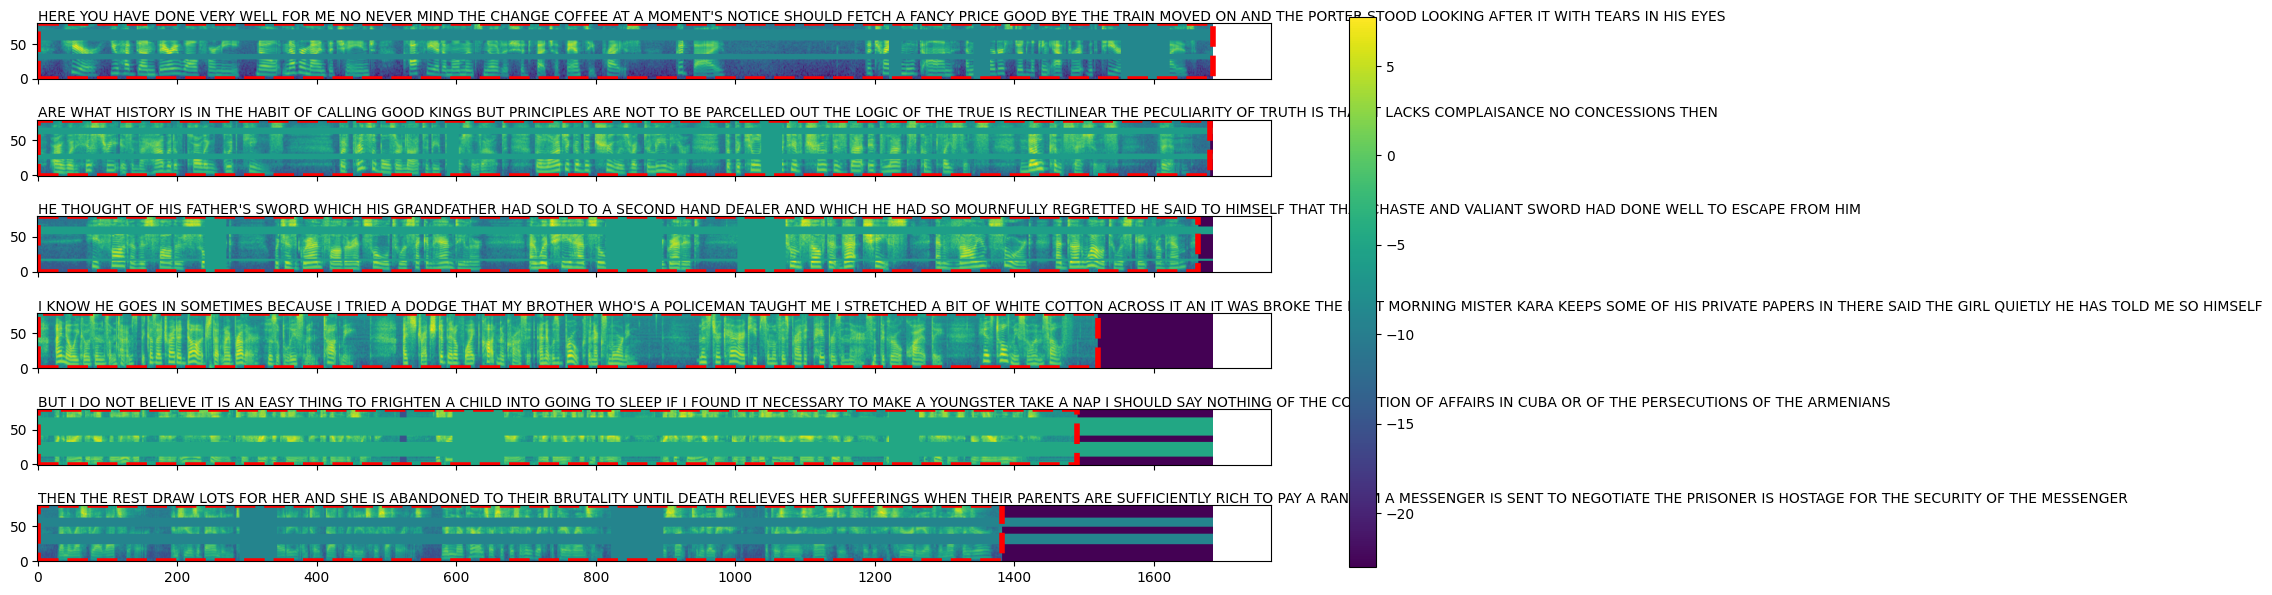

In [11]:
from lhotse.dataset.vis import plot_batch

for batch in train_dloader:
    plot_batch(batch)
    break

---

## Cleanup (Optional)

To remove data from AIStore after the tutorial:

In [12]:
data_bucket.delete(missing_ok=True)